In [3]:
#LIB IMPORTATIONS
"****************************************************"

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
from numba import jit, njit
from time import time
from statsmodels.distributions import ECDF
import seaborn as sns
from sklearn.preprocessing import normalize
import collections as collec
from scipy.interpolate import UnivariateSpline
import os
import random
import plotly.graph_objects as go
import plotly.io as pio
from joblib import Parallel, delayed
import multiprocessing
import constants_maker
import importlib
import util_maker

# $\mathrm{P}(L_{\text{bid}}^{\delta , Q} < h | I, \Delta_{\text{events}} = 300)$ with $h := \text{inf}( t > 0, \Delta _{t}^{bid} < 0 )$

# $\mathrm{P}(L_{\text{ask}}^{0 , 1} < h | I, \Delta_{\text{events}} = 300)$ with $h := \text{inf}( t > 0, \Delta _{t}^{bid} < 0 )$

In [4]:
importlib.reload(constants_maker)
from constants_maker import *
importlib.reload(util_maker)
from util_maker import *

In [5]:
manip_distance_to_multiple_to_imbalance_level_to_values_to_probas_L_bid = get_all_probas_L_bid(get_parallel_data_L_bid())

calculated exec data *** 0.26 bps for manip order distance  in 24.91s
calculated exec data *** 0.01 bps for manip order distance  in 25.82s
calculated exec data *** 1.26 bps for manip order distance  in 26.31s
calculated exec data *** 0.76 bps for manip order distance  in 26.63s
calculated exec data *** 0.51 bps for manip order distance  in 26.89s
calculated exec data *** 1.51 bps for manip order distance  in 26.78s
calculated exec data *** 1.76 bps for manip order distance  in 26.88s
calculated exec data *** 1.01 bps for manip order distance  in 27.06s
calculated exec data *** 2.01 bps for manip order distance  in 12.16s
calculated exec data *** 2.26 bps for manip order distance  in 11.56s
calculated exec data *** 2.51 bps for manip order distance  in 11.28s
calculated exec data *** 2.76 bps for manip order distance  in 11.09s
{0.5: {6: {-1.0: 0, -0.9: 0.0, -0.8: 0.0625, -0.7: 0.08171174078605828, -0.6: 0.11559352716790436, -0.5: 0.08979921185980975, -0.4: 0.13559322033898305, -0.3: 0

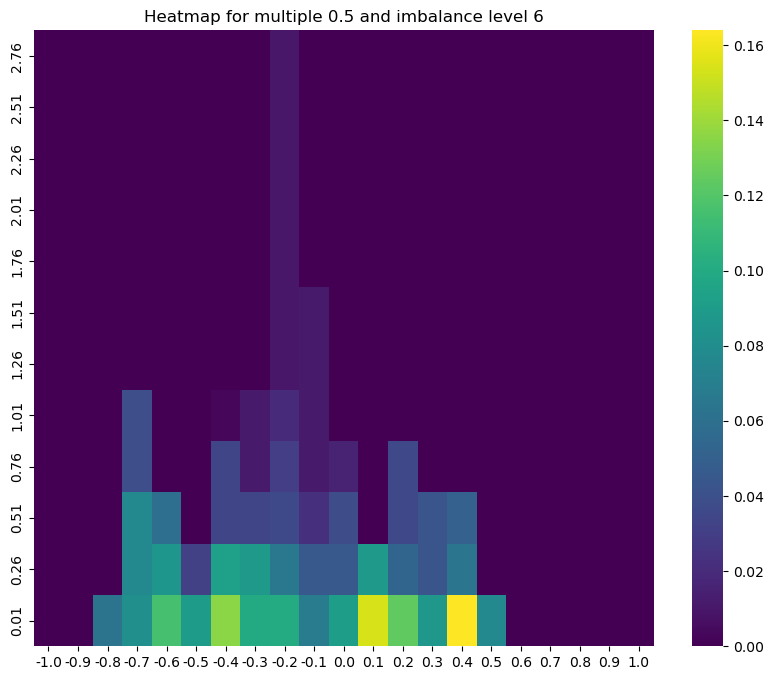

In [6]:
# loop through each multiple
multiple  = constant.MANIP_SIZE_MULTIPLE_RANGE[0]

# build a DataFrame from the nested dictionary for the current multiple and imbalance level
data = {manip_distance: multiple_to_imbalance_level_to_values_to_probas[multiple][6]
        for manip_distance, multiple_to_imbalance_level_to_values_to_probas 
        in manip_distance_to_multiple_to_imbalance_level_to_values_to_probas_L_bid.items()}

df = pd.DataFrame(data).sort_index(axis=1).T

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 8))

# Plotting heatmap using seaborn
ax = sns.heatmap(df, cmap='viridis')
ax.invert_yaxis()


# Setting the title of the plot
ax.set_title(f'Heatmap for multiple {multiple} and imbalance level {6}')

plt.show()

In [7]:
distances_to_imbalances_to_probas_L_ask = get_probas_L_ask(get_orders_data_target())

calculated exec data *** 350 delta_events  in 9.62s


In [8]:
dist_to_imb_to_expect_splined = get_dist_to_imb_to_expect_splined()

calculated exec data *** 350 delta_events in 7.41s


In [9]:
manip_distance_to_imbalance_level_to_values_to_probas_L_bid_L_ask = get_all_probas_L_bid_L_ask(get_parallel_data_L_bid_L_ask())

calculated exec data *** 350 delta_events  in 31.95s
calculated exec data *** 350 delta_events  in 32.58s
calculated exec data *** 350 delta_events  in 33.03s
calculated exec data *** 350 delta_events  in 33.24s
calculated exec data *** 350 delta_events  in 33.76s
calculated exec data *** 350 delta_events  in 33.09s
calculated exec data *** 350 delta_events  in 34.39s
calculated exec data *** 350 delta_events  in 32.76s
calculated exec data *** 350 delta_events  in 17.57s
calculated exec data *** 350 delta_events  in 17.42s
calculated exec data *** 350 delta_events  in 17.13s
calculated exec data *** 350 delta_events  in 17.06s


In [10]:
(timestamps, 
 wealths, 
 imbalances_before,
   imbalances_after,
     distances, Qa_Qb_liste, order_volumes
     ) = get_wealth_values(
         dist_to_imb_to_expect_splined,
                    manip_distance_to_multiple_to_imbalance_level_to_values_to_probas_L_bid,
                    distances_to_imbalances_to_probas_L_ask,
                    manip_distance_to_imbalance_level_to_values_to_probas_L_bid_L_ask)

/Users/paulfaverjon/Desktop/preparation/data/orderbooks_1/orderbooks-5limits-part10.parquet


/Users/paulfaverjon/Desktop/preparation/data/orderbooks_1/orderbooks-5limits-part11.parquet


In [11]:
sum_positive_wealths = sum(w for w in wealths if w > 0)
sum_negative_wealths = -sum(w for w in wealths if w < 0)

print("Sum of positive wealths: ", sum_positive_wealths)
print("Sum of negative wealths: ", sum_negative_wealths)
print("ratio : ", sum_positive_wealths/sum_negative_wealths)

Sum of positive wealths:  101288.62405360877
Sum of negative wealths:  157958932.0807976
ratio :  0.0006412339126336876


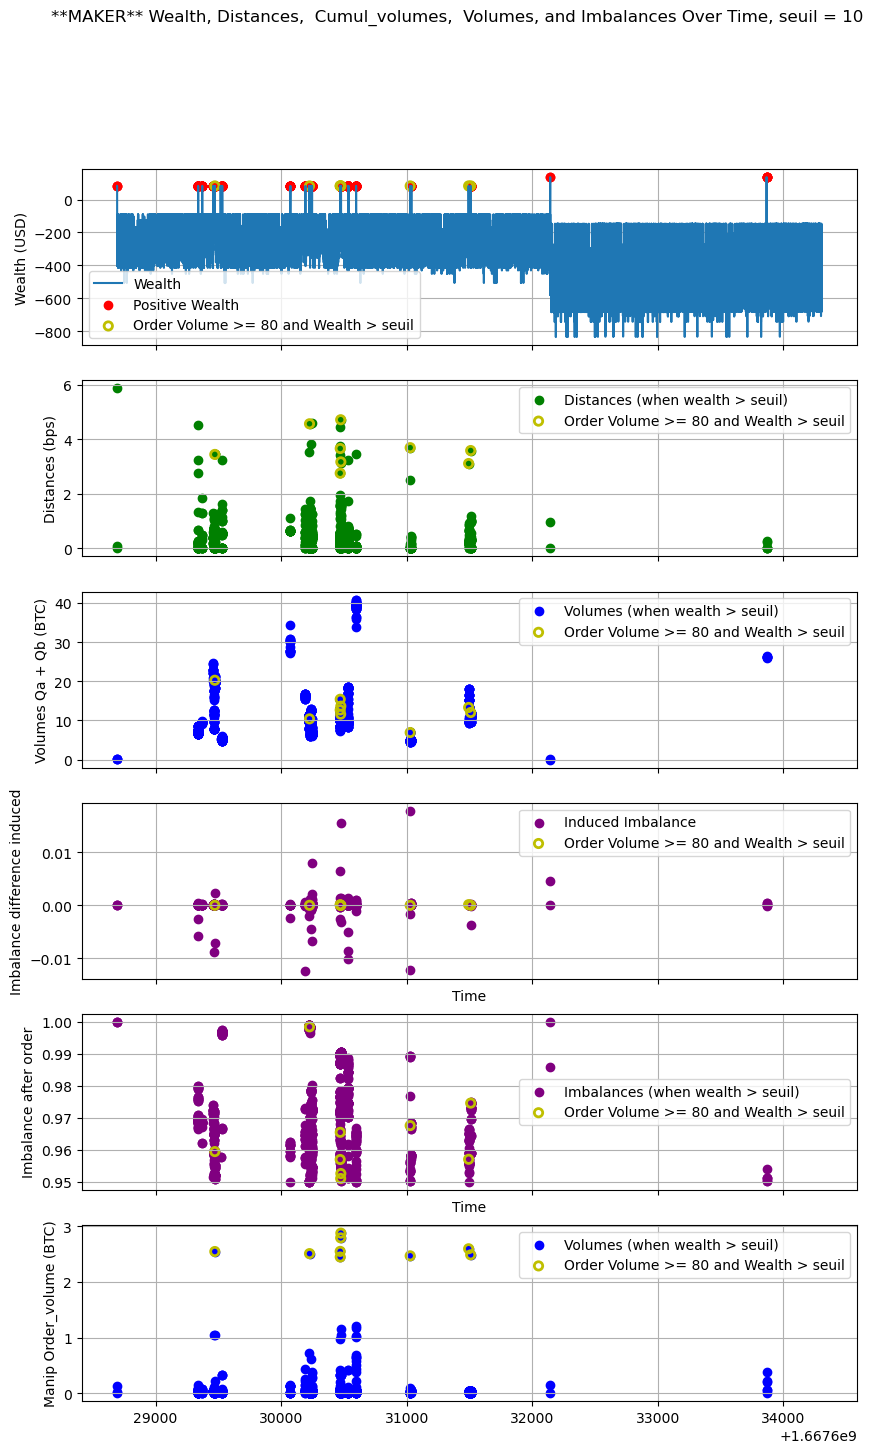

In [12]:
seuil = 10

fig, (ax1, ax2, ax3, ax4, ax4bis, ax5) = plt.subplots(6, sharex=True, figsize=(10, 16))
fig.suptitle(f'**MAKER** Wealth, Distances,  Cumul_volumes,  Volumes, and Imbalances Over Time, seuil = {seuil}')

# Find timestamps where volume is >= 80 and wealth > seuil
high_vol_and_wealth_timestamps = [t for t, v, w in zip(timestamps, order_volumes, wealths) if v >= 2 and w > seuil]
high_vol_and_wealth_wealths = [w for w, v in zip(wealths, order_volumes) if v >= 2 and w > seuil]
high_vol_and_wealth_distances = [d for d, v, w in zip(distances, order_volumes, wealths) if v >= 2 and w > seuil]
high_vol_and_wealth_cumul_volumes = [v for v, v_order, w in zip(Qa_Qb_liste, order_volumes, wealths) if v_order >= 2 and w > seuil]
high_vol_and_wealth_imbalances_difference = np.subtract(
    [i for i, v, w in zip(imbalances_after, order_volumes, wealths) if v >= 2 and w > seuil],
    [i for i, v, w in zip(imbalances_before, order_volumes, wealths) if v >= 2 and w > seuil])
high_vol_and_wealth_imbalances2 = [i for i, v, w in zip(imbalances_after, order_volumes, wealths) if v >= 2 and w > seuil]
high_vol_and_wealth_volumes = [v for v, w in zip(order_volumes, wealths) if v >= 2 and w > seuil]

# Plot wealth over time
ax1.plot(timestamps, wealths, label='Wealth')
positive_timestamps = [t for t, w in zip(timestamps, wealths) if w > seuil]
positive_wealths = [w for w in wealths if w > seuil]
ax1.scatter(positive_timestamps, positive_wealths, color='r', label='Positive Wealth')
ax1.scatter(high_vol_and_wealth_timestamps, high_vol_and_wealth_wealths, edgecolors='y', facecolors='none', linewidths=2, label='Order Volume >= 80 and Wealth > seuil')
ax1.set_ylabel('Wealth (USD)')
ax1.legend()
ax1.grid(True)

# Plot distances when wealth is > seuil
wealthy_timestamps = [t for t, w in zip(timestamps, wealths) if w > seuil]
wealthy_distances = [d for d, w in zip(distances, wealths) if w > seuil]
ax2.scatter(wealthy_timestamps, wealthy_distances, color='g', label='Distances (when wealth > seuil)')
ax2.scatter(high_vol_and_wealth_timestamps, high_vol_and_wealth_distances, edgecolors='y', facecolors='none', linewidths=2, label='Order Volume >= 80 and Wealth > seuil')
ax2.set_ylabel('Distances (bps)')
ax2.legend()
ax2.grid(True)

#Plot volume when wealth is > seuil
wealthy_cumul_volumes = [v for v, w in zip(Qa_Qb_liste, wealths) if w > seuil]
ax3.scatter(wealthy_timestamps, wealthy_cumul_volumes, color='b', label='Volumes (when wealth > seuil)')
ax3.scatter(high_vol_and_wealth_timestamps, high_vol_and_wealth_cumul_volumes, edgecolors='y', facecolors='none', linewidths=2, label='Order Volume >= 80 and Wealth > seuil')
ax3.set_ylabel('Volumes Qa + Qb (BTC)')
ax3.legend()
ax3.grid(True)

# Plot imbalances when wealth is > seuil
wealthy_imbalances_difference = np.subtract(
    [i for i, w in zip(imbalances_after, wealths) if w > seuil],
    [i for i, w in zip(imbalances_before, wealths) if w > seuil])
ax4.scatter(wealthy_timestamps, wealthy_imbalances_difference, color='purple', label = 'Induced Imbalance')
ax4.scatter(high_vol_and_wealth_timestamps, high_vol_and_wealth_imbalances_difference, edgecolors='y', facecolors='none', linewidths=2, label='Order Volume >= 80 and Wealth > seuil')
ax4.set_xlabel('Time')
ax4.set_ylabel('Imbalance difference induced')
ax4.legend()
ax4.grid(True)

# Plot imbalances when wealth is > seuil
wealthy_imbalances2 = [i for i, w in zip(imbalances_after, wealths) if w > seuil]
ax4bis.scatter(wealthy_timestamps, wealthy_imbalances2, color='purple', label='Imbalances (when wealth > seuil)')
ax4bis.scatter(high_vol_and_wealth_timestamps, high_vol_and_wealth_imbalances2, edgecolors='y', facecolors='none', linewidths=2, label='Order Volume >= 80 and Wealth > seuil')
ax4bis.set_xlabel('Time')
ax4bis.set_ylabel('Imbalance after order')
ax4bis.legend()
ax4bis.grid(True)

#Plot volume when wealth is > seuil
wealthy_volumes = [v for v, w in zip(order_volumes, wealths) if w > seuil]
ax5.scatter(wealthy_timestamps, wealthy_volumes, color='b', label='Volumes (when wealth > seuil)')
ax5.scatter(high_vol_and_wealth_timestamps, high_vol_and_wealth_volumes, edgecolors='y', facecolors='none', linewidths=2, label='Order Volume >= 80 and Wealth > seuil')
ax5.set_ylabel('Manip Order_volume (BTC)')
ax5.legend()
ax5.grid(True)

plt.show()